Action space size:  2
State space size:  4
states high value:
4.8
3.4028235e+38
0.41887903
3.4028235e+38
states low value:
-4.8
-3.4028235e+38
-0.41887903
-3.4028235e+38
(1, 1, 6, 12, 2)
Episode:0/1000 finished with a total reward of: 16.0
Episode:1/1000 finished with a total reward of: 23.0
Episode:2/1000 finished with a total reward of: 19.0
Episode:3/1000 finished with a total reward of: 33.0
Episode:4/1000 finished with a total reward of: 23.0
Episode:5/1000 finished with a total reward of: 62.0
Episode:6/1000 finished with a total reward of: 41.0
Episode:7/1000 finished with a total reward of: 14.0
Episode:8/1000 finished with a total reward of: 45.0
Episode:9/1000 finished with a total reward of: 16.0
Episode:10/1000 finished with a total reward of: 16.0
Episode:11/1000 finished with a total reward of: 18.0
Episode:12/1000 finished with a total reward of: 26.0
Episode:13/1000 finished with a total reward of: 21.0
Episode:14/1000 finished with a total reward of: 14.0
Episode:15/10

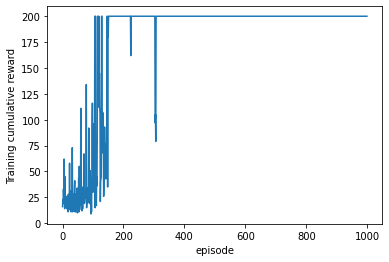

Test episode finished with a total reward of: 200.0
Test episode finished with a total reward of: 200.0
Test episode finished with a total reward of: 200.0
Test episode finished with a total reward of: 200.0
Test episode finished with a total reward of: 200.0
Test episode finished with a total reward of: 200.0
Test episode finished with a total reward of: 200.0
Test episode finished with a total reward of: 200.0
Test episode finished with a total reward of: 200.0
Test episode finished with a total reward of: 200.0
Test episode finished with a total reward of: 200.0
Test episode finished with a total reward of: 200.0
Test episode finished with a total reward of: 200.0


In [ ]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt

# CREATE ENVIRONMENT
env = gym.make('CartPole-v0')
n_actions = env.action_space.n
n_states = env.observation_space.shape[0]
print("Action space size: ", n_actions)
print("State space size: ", n_states)

print('states high value:')
print(env.observation_space.high[0])
print(env.observation_space.high[1])
print(env.observation_space.high[2])
print(env.observation_space.high[3])

print('states low value:')
print(env.observation_space.low[0])
print(env.observation_space.low[1])
print(env.observation_space.low[2])
print(env.observation_space.low[3])


# DOWN-SCALE THE FEATURE SPACE TO DISCRETE RANGE
buckets = (1, 1, 6, 12)     # define the number of buckets for each state value (x, x', theta, theta')

# define upper and lower bounds for each state value
# note: setting the bucket to 1 for the first 2 numbers is equivalent to ignoring these parameters
upper_bounds = [
        env.observation_space.high[0], 
        0.5, 
        env.observation_space.high[2], 
        math.radians(50)
        ]
lower_bounds = [
        env.observation_space.low[0], 
        -0.5, 
        env.observation_space.low[2], 
        -math.radians(50)]


# HYPERPARAMETERS
n_episodes = 1000           # Total train episodes
n_steps = 200               # Max steps per episode
min_alpha = 0.1             # learning rate
min_epsilon = 0.1           # exploration rate
gamma = 1                   # discount factor
ada_divisor = 25            # decay rate parameter for alpha and epsilon

# INITIALISE Q MATRIX
Q = np.zeros(buckets + (n_actions,)) 
print(np.shape(Q))

def discretize(obs):
    ''' discretise the continuous state into buckets ''' 
    ratios = [(obs[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(obs))]
    new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
    new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
    return tuple(new_obs)

def epsilon_policy(state, epsilon):
    ''' choose an action using the epsilon policy '''
    exploration_exploitation_tradeoff = np.random.random()
    if exploration_exploitation_tradeoff <= epsilon:
        action = env.action_space.sample()  # exploration
    else:
        action = np.argmax(Q[state])   # exploitation
    return action

def greedy_policy(state):
    ''' choose an action using the greedy policy '''
    return np.argmax(Q[state])

def update_q(current_state, action, reward, new_state, alpha):
    ''' update the Q matrix with the Bellman equation '''
    Q[current_state][action] += alpha * (reward + gamma * np.max(Q[new_state]) - Q[current_state][action])

def get_epsilon(t):
    ''' decrease the exploration rate at each episode '''
    return max(min_epsilon, min(1, 1.0 - math.log10((t + 1) / ada_divisor)))

def get_alpha(t):
    ''' decrease the learning rate at each episode '''
    return max(min_alpha, min(1.0, 1.0 - math.log10((t + 1) / ada_divisor)))


# TRAINING PHASE
rewards = [] 

for episode in range(n_episodes):
    current_state = env.reset()
    current_state = discretize(current_state)

    alpha = get_alpha(episode)
    epsilon = get_epsilon(episode)

    episode_rewards = 0

    for t in range(n_steps):
        # env.render()
        action = epsilon_policy(current_state, epsilon)
        new_state, reward, done, _ = env.step(action)
        new_state = discretize(new_state)
        update_q(current_state, action, reward, new_state, alpha)
        current_state = new_state

        # increment the cumulative reward
        episode_rewards += reward

        # at the end of the episode
        if done:
            print('Episode:{}/{} finished with a total reward of: {}'.format(episode, n_episodes, episode_rewards))
            break

    # append the episode cumulative reward to the reward list
    rewards.append(episode_rewards)


# PLOT RESULTS
x = range(n_episodes)
plt.plot(x, rewards)
plt.xlabel('episode')
plt.ylabel('Training cumulative reward')
plt.savefig('Q_learning_CART.png', dpi=300)
plt.show()

# TEST PHASE
for episode in range(30):
    current_state = env.reset()
    current_state = discretize(current_state)
    episode_rewards = 0


    for t in range(n_steps):
        env.render()
        action = greedy_policy(current_state)
        new_state, reward, done, _ = env.step(action)
        new_state = discretize(new_state)
        update_q(current_state, action, reward, new_state, alpha)
        current_state = new_state
        episode_rewards += reward

        # at the end of the episode
        if done:
            print('Test episode finished with a total reward of: {}'.format(episode_rewards))
            break
 
env.close()